In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#--export--#
from exports.e_09_Hooks import *

In [3]:
kernel_ns = [8, 16, 32, 32]
data_w = MNISTDataWrapper()
model = nn.Sequential(*cnn_layers(data_w, kernel_ns))
model_w = ModelWrapper(model,
                       optim.SGD(model.parameters(), lr=0.3),
                       torch.functional.F.cross_entropy,
                       data_w)

job = DLJob([AvgStatsCB(),
            BatchTransformCB(mnist_view)])

for l in model:
    if isinstance(l, nn.Sequential):
        torch.nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

# More Activation Visualization with Histograms
To get a better idea of the behaviour of each individual layer in our model, we can plot histograms showing the density of activation values assumes by each neuron.

In [5]:
def append_stats_hist(hook, model, inp, out):
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
    means, stds, hists = hook.stats
    means.append(out.data.mean().cpu())
    stds .append(out.data.std().cpu())
    hists.append(out.data.cpu().histc(bins=40, min=0, max=10)) # a histogram telling us how many activations in each bin

In [7]:
with Hooks(model, append_stats_hist) as hooks: job.fit(1, model_w)

train: [0.9248021875]
valid: [0.28059267578125]


In [54]:
#--export--#
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()
# rows = bins, cols= batch no, value = number of activations

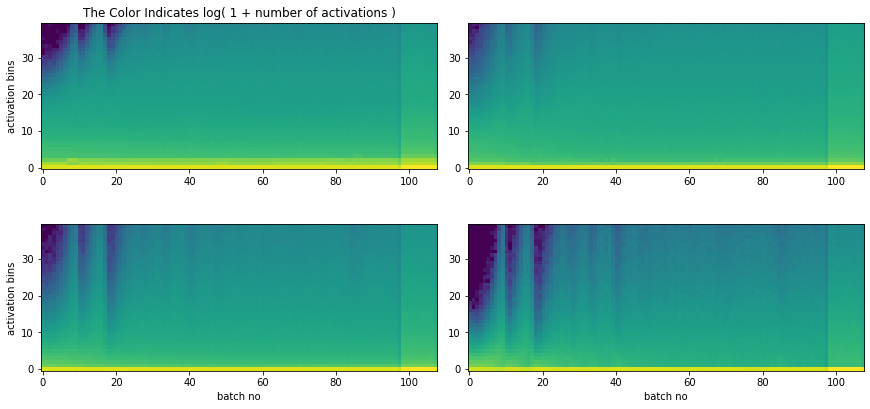

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
plt.tight_layout()
axes[0,0].set_title('The Color Indicates log( 1 + number of activations )')
for ax in axes[1]: ax.set_xlabel('batch no')
for ax in axes[:,0]: ax.set_ylabel('activation bins')

Above, the color indicates the frequency density, it is apparent the solid line at the bottom shows a high number of our neurons are at low activations.


Let's try and get some more stats, like the maximum and minimum activations in each layer.
## Percentage at Minimum and Maximum Activations

In [42]:
def get_max_min_hist(h, mn=True):
    h1 = torch.stack(h.stats[2]).t().float()
    return (h1[:2] if mn else h1[-2:]).sum(0)/h1.sum(0)

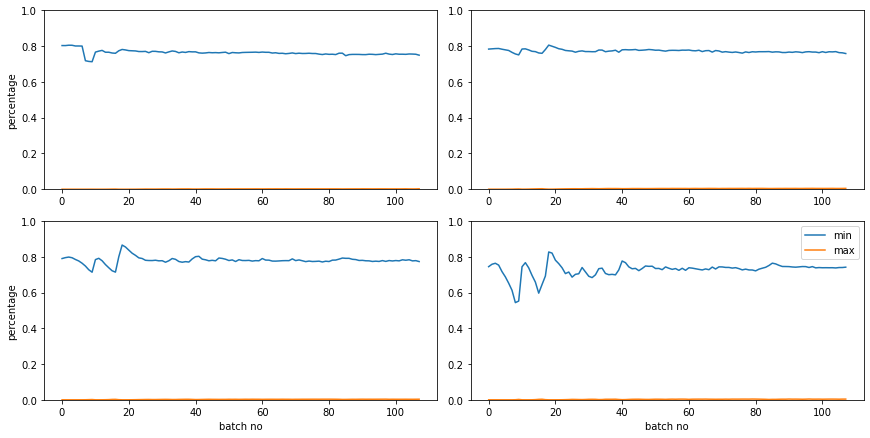

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_max_min_hist(h), label='min')
    ax.plot(get_max_min_hist(h, False), label='max')
    ax.set_ylim(0,1)
plt.tight_layout()
axes[0,0].set_title('')
for ax in axes[1]: ax.set_xlabel('batch no')
for ax in axes[:,0]: ax.set_ylabel('percentage')
plt.legend();

Even with Kaiming initialization, it turns out that ~80% of our activations are accumulating around some minimum value. Oh dear!

In [4]:
!python utils/export_notebook.py 11_MoreStats.ipynb

Notebook 11_MoreStats.ipynb has been converted to module ./exports/e_11_MoreStats.py!
